In [ ]:

!pip install datasets


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 19.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 10.3 MB/s eta 0:00:00


In [ ]:
import pandas as pd
from huggingface_hub import list_datasets

In [ ]:
from datasets import load_dataset
emotions = load_dataset('emotion')
emotions.set_format(type='pandas')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/9.05k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/1.03M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/127k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/129k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [ ]:
df = emotions['train'][:]

In [ ]:
df.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


In [ ]:
classes = emotions['train'].features['label'].names
classes

['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']

In [ ]:
df['label_name'] = df['label'].apply(lambda x: classes[x])

In [ ]:
df.head()

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


In [ ]:
# Data Analysis

In [ ]:
import matplotlib.pyplot as plt

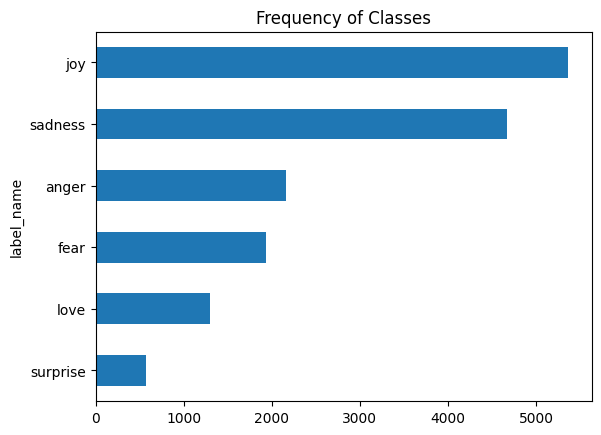

In [ ]:
df['label_name'].value_counts(ascending=True).plot.barh()
plt.title('Frequency of Classes')
plt.show()

<Axes: title={'center': 'words per tweet'}, xlabel='label_name'>

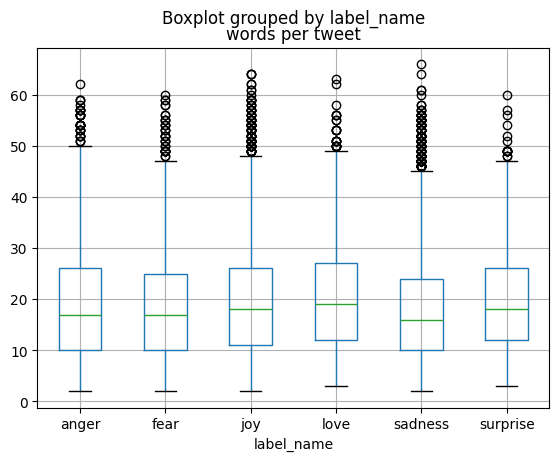

In [ ]:
df['words per tweet'] = df['text'].str.split().apply(len)
df.boxplot('words per tweet', by='label_name')

In [ ]:
from transformers import AutoTokenizer
model_ckpt = 'distilbert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

## Tokenization

In [ ]:
emotions.reset_format()

In [ ]:
def tokenize(batch):
  temp = tokenizer(batch['text'], padding=True, truncation=True)
  return temp

In [ ]:
emotions_encoded = emotions.map(tokenize, batched=True, batch_size=None)

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [ ]:
emotions_encoded

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 2000
    })
})

In [ ]:
train_df = emotions_encoded['train'].to_tf_dataset(
    columns=['input_ids', 'attention_mask'],
    shuffle=True,
    batch_size=32,
    label_cols=['label']
)
val_df = emotions_encoded['validation'].to_tf_dataset(
    columns=['input_ids', 'attention_mask'],
    shuffle=False,
    batch_size=32,
    label_cols=['label']
)
test_df = emotions_encoded['test'].to_tf_dataset(
    columns=['input_ids', 'attention_mask'],
    shuffle=False,
    batch_size=32,
    label_cols=['label']
)

/usr/local/lib/python3.11/dist-packages/datasets/arrow_dataset.py:405: FutureWarning: The output of `to_tf_dataset` will change when a passing single element list for `labels` or `columns` in the next datasets version. To return a tuple structure rather than dict, pass a single string.
Old behaviour: columns=['a'], labels=['labels'] -> (tf.Tensor, tf.Tensor)  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor)  
New behaviour: columns=['a'],labels=['labels'] -> ({'a': tf.Tensor}, {'labels': tf.Tensor})  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor) 
  warnings.warn(


## Model

In [ ]:
import tensorflow as tf
from transformers import TFAutoModelForSequenceClassification
num_labels = 6

model = TFAutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=num_labels)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

In [ ]:
from transformers import AdamWeightDecay

In [ ]:
model.compile(optimizer=AdamWeightDecay(learning_rate=5e-5, weight_decay_rate=0.01),
               loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
               metrics=['accuracy'])

In [ ]:
model.fit(train_df, validation_data=val_df, epochs=3)

Epoch 1/3
500/500 [==============================] - 175s 323ms/step - loss: 0.4553 - accuracy: 0.8406 - val_loss: 0.1886 - val_accuracy: 0.9260
Epoch 2/3
500/500 [==============================] - 154s 307ms/step - loss: 0.1365 - accuracy: 0.9419 - val_loss: 0.1314 - val_accuracy: 0.9375
Epoch 3/3
500/500 [==============================] - 158s 317ms/step - loss: 0.1047 - accuracy: 0.9503 - val_loss: 0.1328 - val_accuracy: 0.9415


In [ ]:
model.evaluate(test_df)

63/63 [==============================] - 8s 85ms/step - loss: 0.1447 - accuracy: 0.9265


[0.14469902217388153, 0.9265000224113464]

In [ ]:
import numpy as np

In [ ]:
text = 'i am sad'
inputs = tokenizer(text, return_tensors='tf', padding=True, truncation=True)
logits = model(**inputs)

logits = logits.logits
pred = np.argmax(logits, axis=1).item()
pred, classes[pred]

(0, 'sadness')